# 实现双向的dynamic_lstm+beam_search
### 基于tensorflow1.4 Seq2seq的实现

encoder使用的是双向的LSTM

In [1]:
import helpers
import tensorflow as tf
from tensorflow.python.util import nest
from tensorflow.contrib import seq2seq,rnn

tf.__version__

tf.reset_default_graph()
sess = tf.InteractiveSession()

PAD = 0
EOS = 1


vocab_size = 10
input_embedding_size = 20
encoder_hidden_units = 25

decoder_hidden_units = encoder_hidden_units

import helpers as data_helpers
batch_size = 10

# 一个generator，每次产生一个minibatch的随机样本

batches = data_helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('产生%d个长度不一（最短3，最长8）的sequences, 其中前十个是:' % batch_size)
for seq in next(batches)[:min(batch_size, 10)]:
    print(seq)
    
tf.reset_default_graph()
sess = tf.InteractiveSession()
mode = tf.contrib.learn.ModeKeys.TRAIN

产生10个长度不一（最短3，最长8）的sequences, 其中前十个是:
[6, 5, 7, 2]
[3, 7, 2, 9, 7, 8]
[2, 9, 2, 8, 9]
[7, 7, 8]
[6, 5, 6, 7, 9, 2, 7]
[6, 2, 3, 6]
[4, 7, 7]
[6, 7, 7, 4, 8, 3, 2, 3]
[8, 4, 5, 4]
[3, 3, 5, 9, 4]


# 1.使用seq2seq库实现seq2seq模型

### 1. 计算图的数据的placeholder

In [2]:
with tf.name_scope('minibatch'):
    encoder_inputs = tf.placeholder(tf.int32, [None, None], name='encoder_inputs')
    
    encoder_inputs_length = tf.placeholder(tf.int32, [None], name='encoder_inputs_length')
    
    decoder_targets = tf.placeholder(tf.int32, [None, None], name='decoder_targets')
    
    decoder_inputs = tf.placeholder(shape=(None, None),dtype=tf.int32,name='decoder_inputs')
    
    #decoder_inputs_length和decoder_targets_length是一样的
    decoder_inputs_length = tf.placeholder(shape=(None,),
                                            dtype=tf.int32,
                                            name='decoder_inputs_length')
  

### 2.设置embedding部分

In [3]:
# 构建embedding矩阵,encoder和decoder公用该词向量矩阵
embedding = tf.get_variable('embedding', [vocab_size,input_embedding_size])
encoder_inputs_embedded = tf.nn.embedding_lookup(embedding,encoder_inputs)

### 3.定义lstm_cell

In [4]:
fw_cell = bw_cell =  rnn.LSTMCell(encoder_hidden_units)

### 4.定义encoder 部分

In [5]:
with tf.variable_scope('encoder'):
    ((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=fw_cell,
                                    cell_bw=bw_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=False)
    )

In [6]:
    encoder_fw_outputs

<tf.Tensor 'encoder/bidirectional_rnn/fw/fw/transpose:0' shape=(?, ?, 25) dtype=float32>

In [7]:
    encoder_bw_outputs

<tf.Tensor 'encoder/ReverseSequence:0' shape=(?, ?, 25) dtype=float32>

In [8]:
    encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'encoder/bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 25) dtype=float32>, h=<tf.Tensor 'encoder/bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 25) dtype=float32>)

In [9]:
    encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'encoder/bidirectional_rnn/bw/bw/while/Exit_2:0' shape=(?, 25) dtype=float32>, h=<tf.Tensor 'encoder/bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 25) dtype=float32>)

#### 对encoder的输出进行合并
输出： 
outputs是一个(output_fw, output_bw)元组，output_fw和output_bw的shape都是[batch_size, sequence_length, num_units]

output_states是一个(output_state_fw, output_state_bw) 元组，分别是前向和后向最后一个Cell的Output，output_state_fw和output_state_bw的类型都是LSTMStateTuple，这个类有两个属性c和h，分别表示Memory Cell和Hidden State，如下图： 
![alt text](figure/basic_lstm_cell.png)

In [10]:
    encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

    encoder_final_state_h = tf.concat((encoder_fw_final_state.h, encoder_bw_final_state.h), 1)
    encoder_final_state_c = tf.concat((encoder_fw_final_state.c, encoder_bw_final_state.c), 1)
    encoder_final_state = rnn.LSTMStateTuple(
        c=encoder_final_state_c,
        h=encoder_final_state_h
    )

In [11]:
    encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'concat_2:0' shape=(?, 50) dtype=float32>, h=<tf.Tensor 'concat_1:0' shape=(?, 50) dtype=float32>)

### 5.定义decoder 部分

In [12]:
def _create_rnn_cell2():
    def single_rnn_cell(encoder_hidden_units):
        # 创建单个cell，这里需要注意的是一定要使用一个single_rnn_cell的函数，不然直接把cell放在MultiRNNCell
        # 的列表中最终模型会发生错误
        single_cell = rnn.LSTMCell(encoder_hidden_units*2)
        #添加dropout
        single_cell = rnn.DropoutWrapper(single_cell, output_keep_prob=0.5)
        return single_cell
            #列表中每个元素都是调用single_rnn_cell函数
            #cell = rnn.MultiRNNCell([single_rnn_cell() for _ in range(self.num_layers)])
    cell = rnn.MultiRNNCell([single_rnn_cell(encoder_hidden_units) for _ in range(1)])
    return cell 

with tf.variable_scope('decoder'):
    #single_cell = rnn.LSTMCell(encoder_hidden_units)
    #decoder_cell = rnn.MultiRNNCell([single_cell for _ in range(1)])
    decoder_cell = rnn.LSTMCell(encoder_hidden_units*2)
    #定义decoder的初始状态
    decoder_initial_state = encoder_final_state
    
    #定义output_layer
    output_layer = tf.layers.Dense(vocab_size,kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    
    decoder_inputs_embedded = tf.nn.embedding_lookup(embedding, decoder_inputs)
    
    # 训练阶段，使用TrainingHelper+BasicDecoder的组合，这一般是固定的，当然也可以自己定义Helper类，实现自己的功能
    training_helper = seq2seq.TrainingHelper(inputs=decoder_inputs_embedded,
                                                        sequence_length=decoder_inputs_length,
                                                        time_major=False, name='training_helper')
    training_decoder = seq2seq.BasicDecoder(cell=decoder_cell, helper=training_helper,
                                                       initial_state=decoder_initial_state,
                                                       output_layer=output_layer)
    
    # 调用dynamic_decode进行解码，decoder_outputs是一个namedtuple，里面包含两项(rnn_outputs, sample_id)
    # rnn_output: [batch_size, decoder_targets_length, vocab_size]，保存decode每个时刻每个单词的概率，可以用来计算loss
    # sample_id: [batch_size], tf.int32，保存最终的编码结果。可以表示最后的答案
    max_target_sequence_length = tf.reduce_max(decoder_inputs_length, name='max_target_len')
    decoder_outputs, _, _ = seq2seq.dynamic_decode(decoder=training_decoder,
                                                          impute_finished=True,
                                                          maximum_iterations=max_target_sequence_length)
    decoder_logits_train = tf.identity(decoder_outputs.rnn_output)
    sample_id = decoder_outputs.sample_id
    max_target_sequence_length = tf.reduce_max(decoder_inputs_length, name='max_target_len')
    mask = tf.sequence_mask(decoder_inputs_length,max_target_sequence_length, dtype=tf.float32, name='masks')
    print('\t%s' % repr(decoder_logits_train))
    print('\t%s' % repr(decoder_targets))
    print('\t%s' % repr(sample_id))
    loss = seq2seq.sequence_loss(logits=decoder_logits_train,targets=decoder_targets, weights=mask)

	<tf.Tensor 'decoder/Identity:0' shape=(?, ?, 10) dtype=float32>
	<tf.Tensor 'minibatch/decoder_targets:0' shape=(?, ?) dtype=int32>
	<tf.Tensor 'decoder/decoder/transpose_1:0' shape=(?, ?) dtype=int32>


In [13]:
with tf.variable_scope('decoder',reuse=True):
    start_tokens = tf.ones([batch_size, ], tf.int32)*1  #[batch_size]  数值为1
    encoder_state = nest.map_structure(lambda s: seq2seq.tile_batch(s, 3),
                                                   encoder_final_state)
    inference_decoder = tf.contrib.seq2seq.BeamSearchDecoder(cell=decoder_cell, embedding=embedding,
                                                                             start_tokens=start_tokens,
                                                                             end_token=1,
                                                                             initial_state=encoder_state,
                                                                             beam_width=3,
                                                                             output_layer=output_layer)
    beam_decoder_outputs, _, _ = seq2seq.dynamic_decode(decoder=inference_decoder,maximum_iterations=10)
    

In [14]:
train_op = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
sess.run(tf.global_variables_initializer())
def next_feed():
    batch = next(batches)
    
    encoder_inputs_, encoder_inputs_length_ = data_helpers.batch(batch)
    decoder_targets_, decoder_targets_length_ = data_helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, decoder_inputs_length_ = data_helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    
    # 在feedDict里面，key可以是一个Tensor
    return {
        encoder_inputs: encoder_inputs_.T,
        decoder_inputs: decoder_inputs_.T,
        decoder_targets: decoder_targets_.T,
        encoder_inputs_length: encoder_inputs_length_,
        decoder_inputs_length: decoder_inputs_length_
    }

x = next_feed()
print('encoder_inputs:')
print(x[encoder_inputs][0,:])
print('encoder_inputs_length:')
print(x[encoder_inputs_length][0])
print('decoder_inputs:')
print(x[decoder_inputs][0,:])
print('decoder_inputs_length:')
print(x[decoder_inputs_length][0])
print('decoder_targets:')
print(x[decoder_targets][0,:])

encoder_inputs:
[6 6 3 4 9 7 4 7]
encoder_inputs_length:
8
decoder_inputs:
[1 6 6 3 4 9 7 4 7]
decoder_inputs_length:
9
decoder_targets:
[6 6 3 4 9 7 4 7 1]


In [15]:
loss_track = []
max_batches = 6001
batches_in_epoch = 200

try:
    # 一个epoch的learning
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(beam_decoder_outputs.predicted_ids, fd)
            #print(predict_)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs], predict_)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
        
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.3011417388916016
  sample 1:
    input     > [4 3 6 6 3 7 7 5]
    predicted > [[9 9 9]
 [9 9 9]
 [6 6 6]
 [6 6 6]
 [6 6 6]
 [5 6 6]
 [6 5 5]
 [6 6 6]
 [6 6 6]
 [5 5 8]]
  sample 2:
    input     > [3 5 3 4 7 0 0 0]
    predicted > [[ 0  0  0]
 [ 4  4  4]
 [ 4  4  4]
 [ 4  4  4]
 [ 9  9  9]
 [ 4  4  4]
 [ 9  9  9]
 [ 7  7  7]
 [ 1  7  1]
 [ 1  7 -1]]
  sample 3:
    input     > [7 4 8 9 9 2 0 0]
    predicted > [[ 9  9  9]
 [ 9  9  9]
 [ 5  5  5]
 [ 0  0  0]
 [ 7  6  6]
 [ 1  6  6]
 [-1  7  7]
 [-1  7  7]
 [-1  7  7]
 [-1  2  7]]

batch 200
  minibatch loss: 1.5333470106124878
  sample 1:
    input     > [6 7 4 2 7 3 0]
    predicted > [[6 6 6]
 [6 6 6]
 [7 7 3]
 [3 3 7]
 [7 3 3]
 [3 3 3]
 [1 1 1]]
  sample 2:
    input     > [7 5 8 5 0 0 0]
    predicted > [[ 5  5  7]
 [ 5  5  5]
 [ 5  5  5]
 [ 1  1  5]
 [ 1 -1  1]
 [-1 -1 -1]
 [-1 -1 -1]]
  sample 3:
    input     > [7 9 7 6 7 2 0]
    predicted > [[5 5 5]
 [7 7 7]
 [7 3 7]
 [3 7 3]
 [7 7 3]
 [3 3 3]
 [1 1

loss 0.0543 after 60010 examples (batch_size=10)


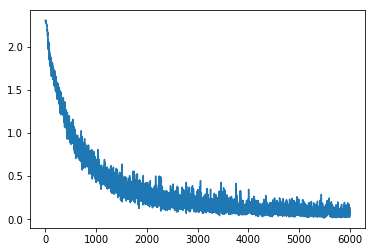

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], 
                                                             len(loss_track)*batch_size, batch_size))